**Author:** Boren Tsai & Zhanyuan Zhang  
**Date:** 9.23.2018  
**Purpose:** This script help calculate the false discovery rate and the C-statistics of the model trained on July 29th, by Yichen Fang.  

In [1]:
import keras
import matplotlib.pyplot as plt
import numpy as np
from utility import load_model

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
# Input the name of the model and its weights
model_name = "729model"
model_weights = "729model_weights"

# Generate the path of the model and its weights
model_path = "models/" + model_name + ".json"
weights_path = "models/" + model_weights + ".h5"

In [3]:
model = load_model(model_path, weights_path)

Loaded model from models/729model.json


**Before we calculate the FDR and C-statistics, we need to generate or import the input data and the correct labels.** Most of the code is adapted from the experiment on July 29th.

In [4]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [5]:
real_buffer_path = "/home/ubuntu/newOutput/10_percent/random_0.1_instance_7.txt"
random_buffer_path = "/home/ubuntu/formatted/random_sequences/random_sequence_buffer.txt"
curtail_len = 3000
motif_num = 3

In [6]:
with open(real_buffer_path, "rb") as buff:
    seq_record_list = pickle.load(buff)
train_val_num = len(seq_record_list)
train_val_num

8088

In [8]:
# A helper function to flatten a 2d list to 1d.
# Input: [[1, 2], [2, 3], [3, 4, 5]]
# Output: [1, 2, 2, 3, 3, 4, 5]
def flatten(lst):
    new_lst = []
    for sub_lst in lst:
        for item in sub_lst:
            new_lst.append(item)
    return new_lst

# A helper function to transform a lst so that its length becomes read_len by:
# 1. If len(lst) > read_len, curtail the end of the lst.
# 2. If len(lst) < read_len, keep extending the end of the lst with 0 (NA).
def curtail(lst, read_len, motif_number):
    if len(lst) > read_len:
        lst = lst[:read_len]
    else:
        for i in range(read_len - len(lst)):
            lst.append([0 for _ in range(motif_number + 4)])
    return lst

# Produce the train-test split
# length_read: the length that you want all DNA sequences to conform to
def prepare_input(training_size, length_read, original_list, motif_number):
    X_train = []
    y_train = []
    seq_count = 0
    while seq_count < training_size:
        X_train.append(flatten(curtail(original_list[seq_count][3], length_read, motif_number)))
        y_train.append(int(original_list[seq_count][1]))
        seq_count += 1
    return X_train, y_train

# Turn list into numpy tensors that can directly feed into a neural network model
def to_np_array(X_train, y_train):
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    if len(y_train.shape) == 1:
        y_train = np.transpose(np.array([y_train]))
    return X_train, y_train

In [11]:
train_val_num = len(seq_record_list)
train_val_num
X_train, y_train = prepare_input(train_val_num, curtail_len, seq_record_list, motif_num)
X_train, y_train = to_np_array(X_train, y_train)
[X_train.shape, y_train.shape]

[(8088, 21000), (8088, 1)]

In [15]:
X_train = X_train.reshape(train_val_num, curtail_len, motif_num + 4)
results = model.predict(X_train, batch_size=16)

# False Discovery Rate
This cell uses the model to make predictions on our data.

Then it iterates through the results and the real labels and compares them to check for False Positives(FP) and True Positives(TP).

Then it uses the formula to calculate the False Discovery Rate (FDR)

In [16]:
false_positives = 0
true_positives = 0
total_negatives = 0
total_positives = 0
true_negatives = 0

for i in range(0,results.size):
    
    if results[i][0]>=0.5 and y_train[i]==0:
        false_positives += 1

    if results[i][0]>=0.5 and y_train[i]==1:
        true_positives += 1
        
    if results[i][0]<=0.5 and y_train[i]==0:
        true_negatives += 1
        
    if results[i][0] <= 0.5:
        total_negatives += 1
        
    if results[i][0] >= 0.5:
        total_positives += 1

false_discovery_rate = false_positives/(false_positives + true_positives)
print("The false discovery rate is: {}".format(false_discovery_rate))

The false discovery rate is: 0.4111111111111111


# C-statistics
This cell iterates through the data using an incrementing threshold value to generate an ROC Curve then uses a Riemann sum (trapezoidal) to generate the C-statistic

ROC Curve


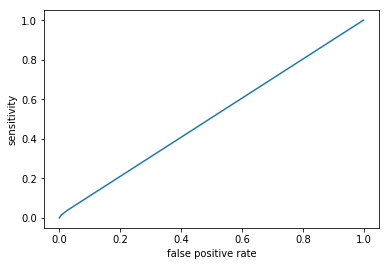

c-statistic = 0.5066006962227262


In [18]:
sensitivities = []
false_positive_rates =[]
discovery_percentage = 0.05

while discovery_percentage < 1.0:
    
    false_positives = 0
    true_positives = 0
    total_negatives = 0
    total_positives = 0
    true_negatives = 0
    
    for i in range(0,results.size):

        if results[i][0]>=discovery_percentage and y_train[i]==0:
            false_positives += 1

        if results[i][0]>=discovery_percentage and y_train[i]==1:
            true_positives += 1

        if results[i][0]<=discovery_percentage and y_train[i]==0:
            true_negatives += 1

        if y_train[i]==0:
            total_negatives += 1

        if y_train[i]==1:
            total_positives += 1
            
    if total_positives != 0 and total_negatives != 0:
        sensitivities.append(true_positives / total_positives)
        false_positive_rates.append(1-(true_negatives / total_negatives))
    
    discovery_percentage += 0.05
    
riemann = 0.0
for i in range(0,len(sensitivities) - 1):
    riemann += 0.5 * (sensitivities[i]+sensitivities[i+1]) * (false_positive_rates[i]-false_positive_rates[i+1])
    

print("ROC Curve")
plt.plot(false_positive_rates, sensitivities )
plt.ylabel('sensitivity')
plt.xlabel('false positive rate')
plt.show()
print("c-statistic = " + str(riemann))